In [1]:
#!pip install plotly

### 0. The similarity and difference between my reproduction and figures in the thesis

In my reproduction, I set all the elevation as 0, and only changed the horizontal angle.

#### 0.1 Fig 13
My reproduction:
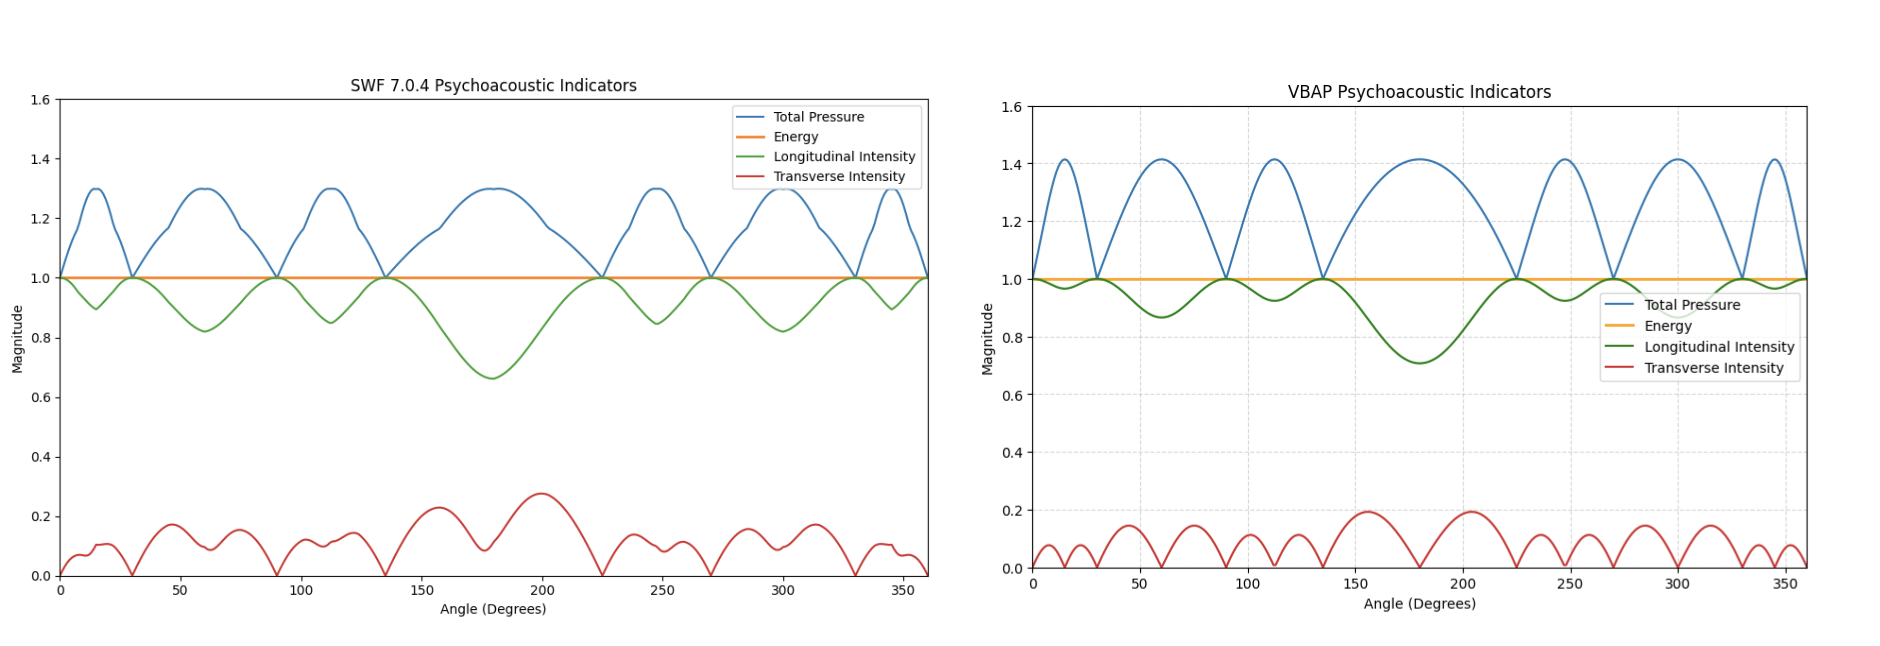

The figure in Samuel's thesis:
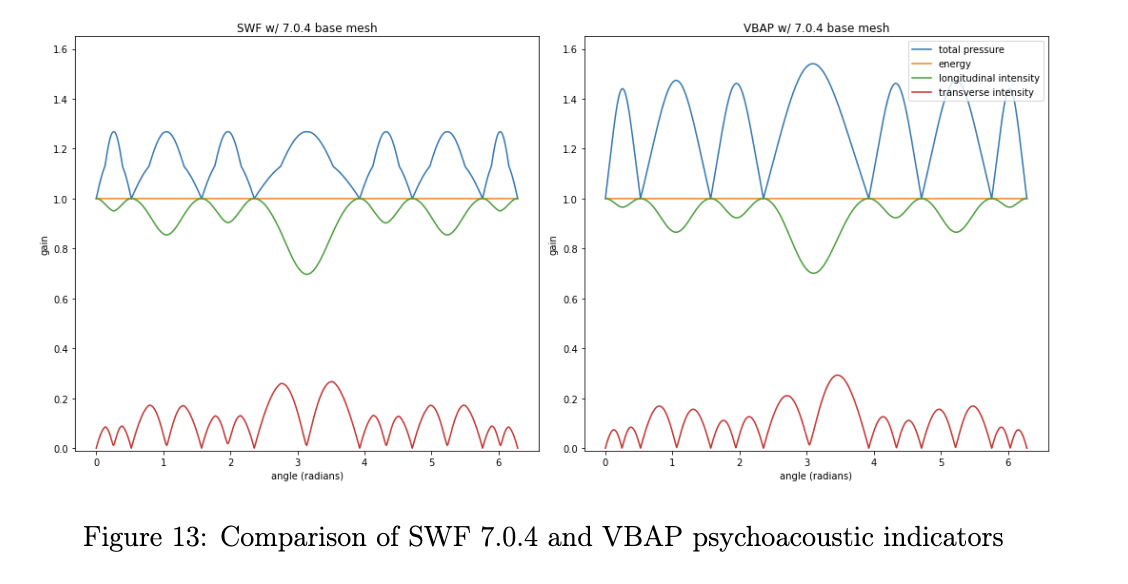


The contours of these lines are similar, but there are nuanced differences. For example, the transverse intensity of the SWF is symmetrical in Samuel's thesis, but not in my reproduction. The peak of the total pressure of the VBAP reaches 1.5, whereas in my reproduction it is around 1.4.

#### 0.2 Fig. 14
My reproduction:
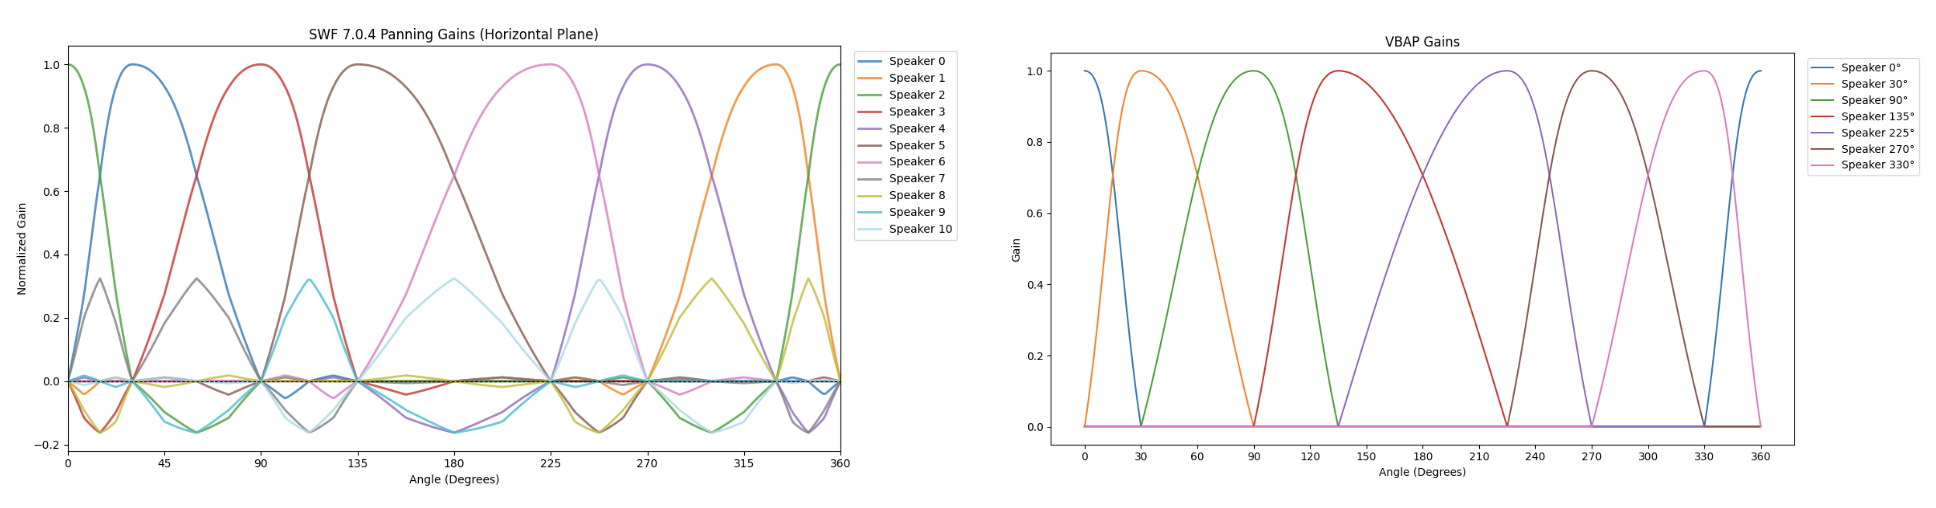

The figure in Samuel's thesis:
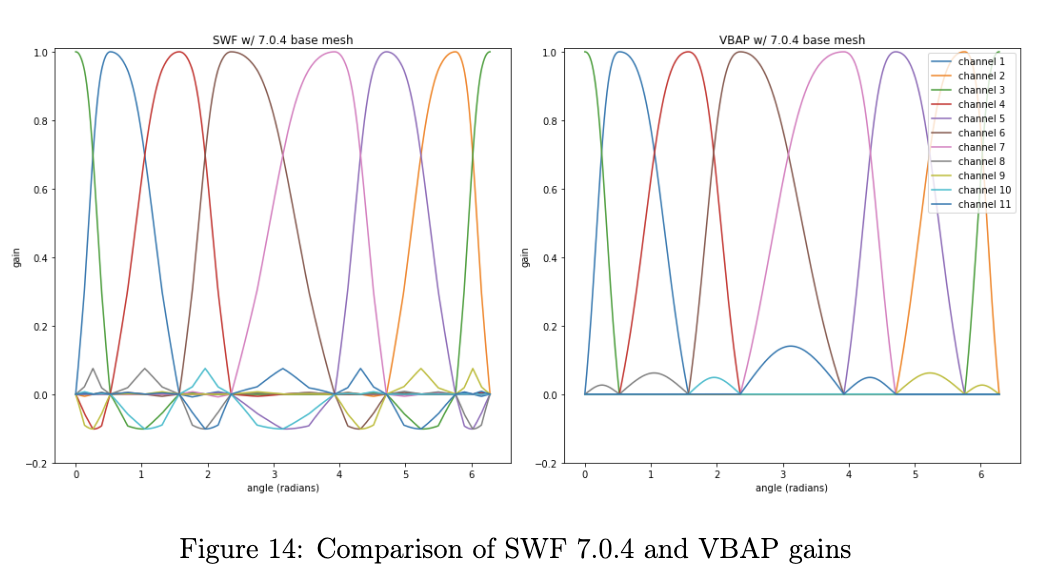

The contours are also similar here. However, the peaks of the small lobes in the reproduction are higher than 0.2, whereas they should be close to 0. Since I set the elevation angle to 0, only 2 speakers are activated at most. However, in Samuel's thesis, a maximum of 3 speakers are activated. So, perhaps he didn’t set the elevation to zero.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 1.VBAP


In [3]:
class VBAP():
  def __init__(self, speaker_angles):
    self.speakers = np.deg2rad(speaker_angles)

  def choose_speakers(self,target_degree):
    radian = np.deg2rad(target_degree + 360) # In case -360 < degree < 0
    radian = radian % (2 * np.pi) # In case degree > 360
    n = len(self.speakers)

    for i in range(n-1):
      speaker1 = self.speakers[i]
      speaker2 = self.speakers[i+1]

      #if the target is between the pair
      if speaker1 <= radian <= speaker2:
                return speaker1, speaker2
    return self.speakers[-1], self.speakers[0]

  def calculate_gain(self, s1_rad, s2_rad, target_degree):
    target_rad = np.deg2rad(target_degree)
    # Vectors of speakers
    l1 = np.array([np.cos(s1_rad), np.sin(s1_rad)])
    l2 = np.array([np.cos(s2_rad), np.sin(s2_rad)])

    # Vectors of the target
    T = np.array([np.cos(target_rad), np.sin(target_rad)]) # t = g1*l1 + g2*l2

    # Matrix solving
    L = np.column_stack((l1, l2))
    g = np.linalg.solve(L, T)

    scaling_factor = np.sqrt(np.sum(g**2))
    g_final = g / scaling_factor

    return g_final[0], g_final[1], s1_rad, s2_rad






In [4]:
speaker_angles = [0, 30, 90, 135, 225, 270, 330]
speaker_radians = list(np.deg2rad(speaker_angles))
vbap = VBAP(speaker_angles)

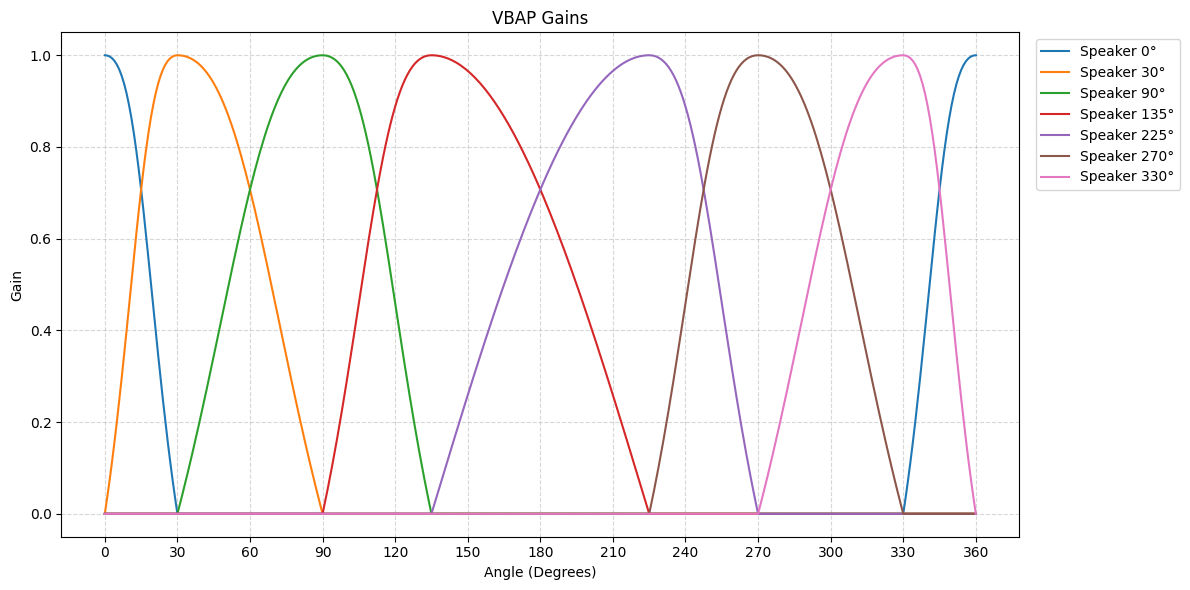

In [5]:
plot_angles = np.arange(0, 361, 1)
gains_history = []

for target in plot_angles:
  # Initialize gains as zeros
  current_row_gains = [0.0] * len(speaker_angles)

  # choose speakers and calculate gains
  s1, s2 = vbap.choose_speakers(target)
  g1, g2, _, _ = vbap.calculate_gain(s1, s2, target)



  index_1 = speaker_radians.index(s1)
  index_2 = speaker_radians.index(s2)

  current_row_gains[index_1] = g1
  current_row_gains[index_2] = g2

  gains_history.append(current_row_gains)

gains_data = np.array(gains_history)

plt.figure(figsize=(12, 6))


# Draw lines of gains of speakers
for i in range(len(speaker_angles)):
  plt.plot(plot_angles, gains_data[:, i],
            label=f'Speaker {speaker_angles[i]}°',
            markersize=4)

plt.title('VBAP Gains')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Gain')
plt.xticks(np.arange(0, 361, 30))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/sh/z5rg6kjj2c98hs77qr9kcs900000gn/T/ipykernel_50894/3407859274.py:44: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  I_trans = np.linalg.norm(np.cross(I_vec, t_vec))


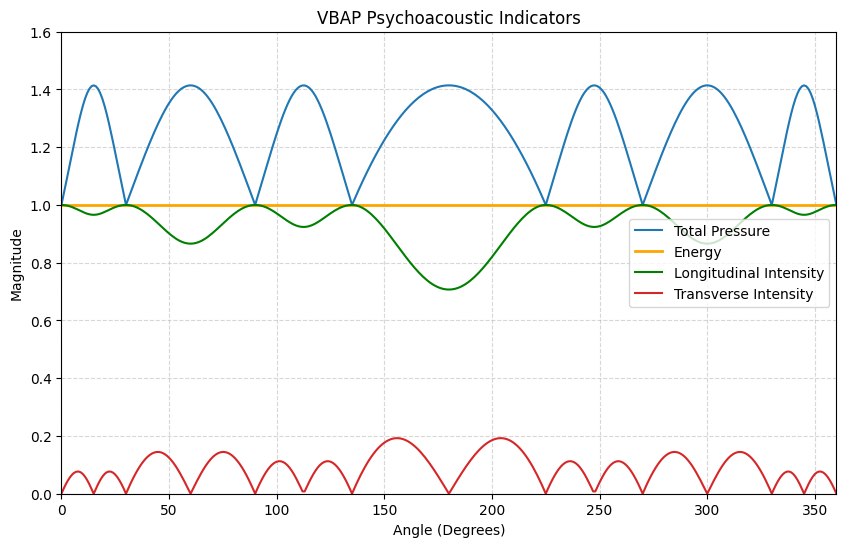

In [6]:
import numpy as np
import matplotlib.pyplot as plt

speaker_angles = [0, 30, 90, 135, 225, 270, 330]
vbap = VBAP(speaker_angles)
plot_angles = np.arange(0, 361, 1) # Use finer resolution for smoother curves

# Initialize lists to store history data
history_energy = []
history_pressure = []
history_longitudinal = []
history_transverse = []

for target_deg in plot_angles:
    s1_rad, s2_rad = vbap.choose_speakers(target_deg)
    g1, g2, _, _ = vbap.calculate_gain(s1_rad, s2_rad, target_deg)


    t_rad = np.deg2rad(target_deg)

    # Target Unit Vector t
    t_vec = np.array([np.cos(t_rad), np.sin(t_rad)])

    # Loudspeaker Unit Vectors l1, l2
    l1_vec = np.array([np.cos(s1_rad), np.sin(s1_rad)])
    l2_vec = np.array([np.cos(s2_rad), np.sin(s2_rad)])

    # Energy，Should be constant at 1.0 (due to normalization)
    E = g1**2 + g2**2

    # Total Pressure， Will fluctuate (constructive interference)
    P = g1 + g2

    # Resultant Intensity Vector I
    # Weighted sum using gain squared (g^2)
    I_vec = ((g1**2 * l1_vec) + (g2**2 * l2_vec))/1

    # Longitudinal Intensity (Dot Product)
    # Projection of Intensity vector onto Target vector
    I_long = np.dot(I_vec, t_vec)

    # Transverse Intensity (Cross Product)
    # Magnitude of the component perpendicular to the Target vector
    I_trans = np.linalg.norm(np.cross(I_vec, t_vec))


    # Append results to history lists
    history_energy.append(E)
    history_pressure.append(P)
    history_longitudinal.append(I_long)
    history_transverse.append(I_trans)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(plot_angles, history_pressure, label='Total Pressure', color='tab:blue')
plt.plot(plot_angles, history_energy, label='Energy', color='orange', linewidth=2)
plt.plot(plot_angles, history_longitudinal, label='Longitudinal Intensity', color='green')
plt.plot(plot_angles, history_transverse, label='Transverse Intensity', color='tab:red')

plt.title('VBAP Psychoacoustic Indicators')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, 360)
plt.ylim(0, 1.6)
plt.show()

### 2. SWF

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from trimesh import Trimesh
from swf import SWF
from constants import vertices704, faces704 
from utils import *

In [8]:
# 1. Culculate gain
base_mesh = Trimesh(vertices=vertices704, faces=faces704)
swf = SWF(base_mesh, n=2)

target_deg = 45
theta = np.deg2rad(target_deg)
target_vector = np.array([np.cos(theta), np.sin(theta), 0.0]) # x = cos(theta), y = sin(theta), z = 0
fine_signal = swf.interpolate(target_vector)
raw_gains = swf.encode(fine_signal)
energy = np.sum(raw_gains**2)
final_gains = raw_gains / np.sqrt(energy)

for i, g in enumerate(final_gains.flatten()):
    print(f"Speaker {i}: {g:.4f}")



Speaker 0: 0.9303
Speaker 1: 0.0000
Speaker 2: -0.0973
Speaker 3: 0.2736
Speaker 4: 0.0000
Speaker 5: 0.0122
Speaker 6: 0.0000
Speaker 7: 0.1824
Speaker 8: -0.0182
Speaker 9: -0.1277
Speaker 10: 0.0122


Calculating gains for 361 angles...


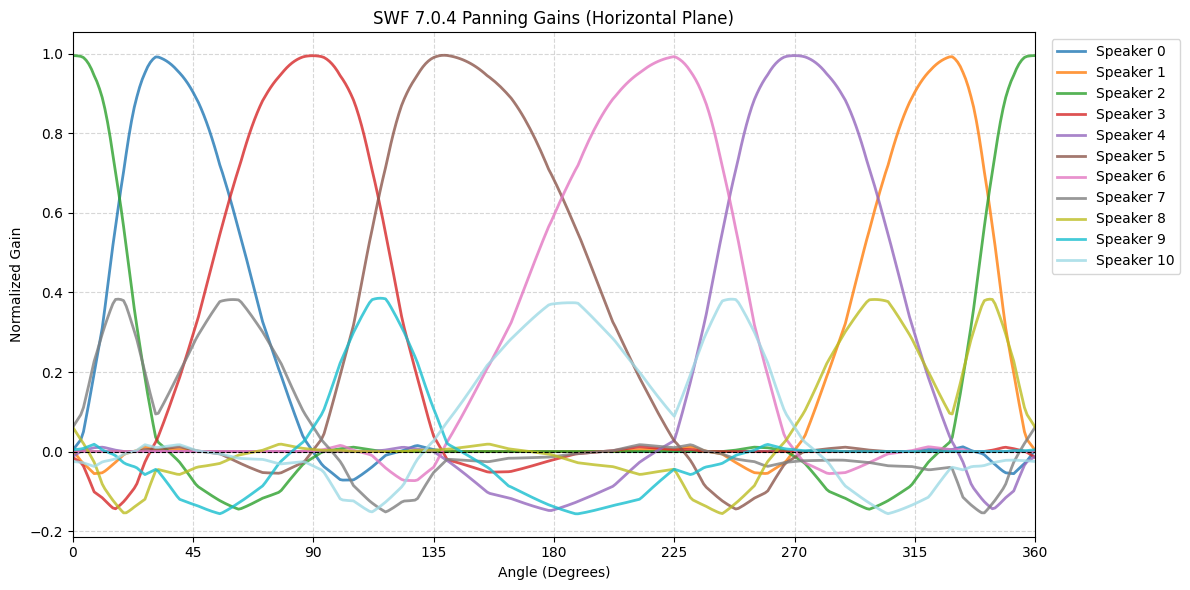

In [13]:


# 1. Initialize System
base_mesh = Trimesh(vertices=vertices704, faces=faces704)
swf = SWF(base_mesh, n=2)

# 2. Prepare calculation points (0 to 360 degrees)
angles = np.arange(0, 361, 1) 
gains_history = []

print(f"Calculating gains for {len(angles)} angles...")

# 3. Calculation Loop
for deg in angles:
    # A. Convert angle to vector (Horizontal plane z=0)
    theta = np.deg2rad(deg)
    target_vector = np.array([np.cos(np.deg2rad(5))*np.cos(theta),
                              np.cos(np.deg2rad(5))*np.sin(theta), 
                              np.sin(np.deg2rad(5))])
    
    # B. SWF Core Operations
    # Interpolate on fine mesh
    fine_signal = swf.interpolate(target_vector)
    
    # Encode to coarse gains
    raw_gains = swf.encode(fine_signal)
    
    # C. Energy Normalization
    energy = np.sum(raw_gains**2)
    final_gains = raw_gains / np.sqrt(energy)
        
    gains_history.append(final_gains.flatten())

gains_data = np.array(gains_history)

# 4. Plotting
plt.figure(figsize=(12, 6))

num_speakers = gains_data.shape[1]
colors = plt.cm.tab20(np.linspace(0, 1, num_speakers))

for i in range(num_speakers):
    plt.plot(angles, gains_data[:, i], 
             label=f'Speaker {i}', 
             color=colors[i], 
             linewidth=2, 
             alpha=0.8)

# Basic chart styling
plt.title('SWF 7.0.4 Panning Gains (Horizontal Plane)')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Normalized Gain')
plt.xlim(0, 360)

# Set x-ticks every 45 degrees for readability
plt.xticks(np.arange(0, 361, 45))

# Zero gain reference line
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

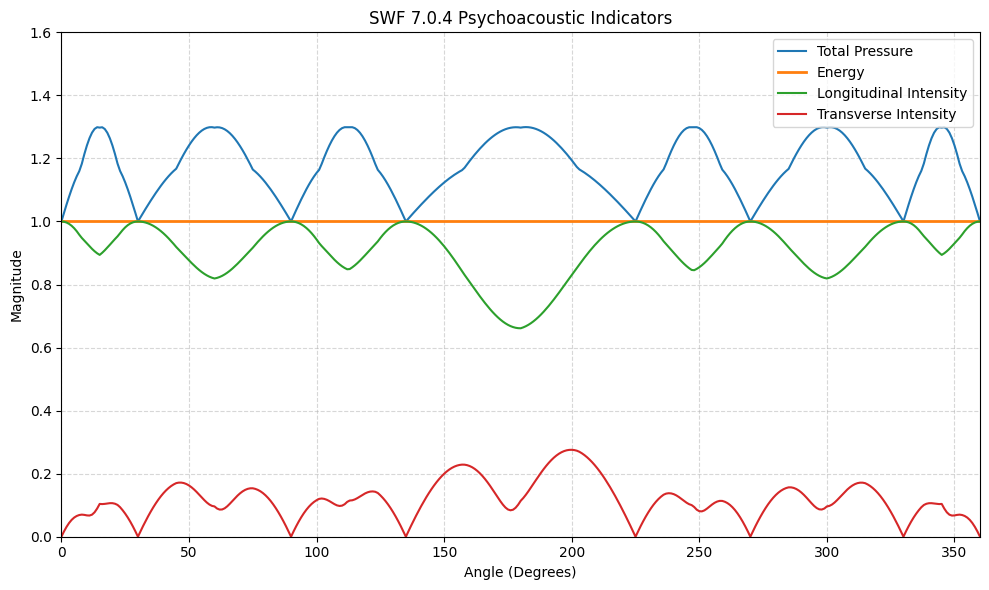

In [10]:
angles = np.arange(0, 361, 1) 
hist_pressure = []; hist_energy = []; hist_Il = []; hist_It = []

for deg in angles:
    # 1. Target Vector (Horizontal)
    theta = np.deg2rad(deg)
    target_vector = np.array([np.cos(np.deg2rad(0))*np.cos(theta),
                              np.cos(np.deg2rad(0))*np.sin(theta), 
                              np.sin(np.deg2rad(0))])
    
    # 2. SWF Calculation
    fine = swf.interpolate(target_vector)
    raw = swf.encode(fine)
    
    # 3. Normalize Energy
    e_val = np.sum(raw**2)
    final_gains = raw / np.sqrt(e_val) if e_val > 1e-9 else raw
    
    # 4. Calculate Indicators
    p = np.sum(final_gains)
    
    eng = np.sum(np.absolute(final_gains)**2)
    
    Il, It = intensity(final_gains, swf.base.vertices, target_vector)
    
    hist_pressure.append(p)
    hist_energy.append(eng)
    hist_Il.append(Il)
    hist_It.append(It)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(angles, hist_pressure, label='Total Pressure', color='tab:blue')
plt.plot(angles, hist_energy, label='Energy', color='tab:orange', linewidth=2)
plt.plot(angles, hist_Il, label='Longitudinal Intensity', color='tab:green')
plt.plot(angles, hist_It, label='Transverse Intensity', color='tab:red')

plt.title('SWF 7.0.4 Psychoacoustic Indicators')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Magnitude')
plt.xlim(0, 360)
plt.ylim(0, 1.6)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()